## Trabalho Final - Reinforcement Learning
RM: 358770 - Erika Koyanagui

RM: 358488 - Fabio Asnis Campos da Silva

RM: 359283 - Lucas Huber Pissaia

RM: 358477 - Matheus Raeski

Neste trabalho, como parte do time de analistas da Quantum Finance, desenvolvemos um agente capaz de dar suporte em tomadas de decisões financeira, como compra, venda ou manutenção de ativos do mercado. Trabalhamos tendo como base dados históricos das seguintes empresas: Vale, Petrobrás e Brasil Foods.

A abordagem escolhida foi a Q-learning.

A descrição de cada etapa e decisão encontram-se no decorrer do código. Nossas conclusões sobre o trabalho, qual outra abordagem de RL é adequada assim como futuros passos, encontram-se na etapa final.

# Pseudocódigo do Algoritmo Q-Learning

1. **Inicializar** Q-table com zeros para todos os pares (estado, ação).
2. Para cada episódio até `num_episodes`:
   1. Resetar o ambiente e obter estado inicial `s`.
   2. Enquanto o episódio não termina (`done == False`):
      1. Selecionar ação `a` usando política ε-greedy baseada em Q(s,·).
      2. Executar ação `a` no ambiente; observar recompensa `r` e próximo estado `s'`.
      3. Atualizar Q(s,a):
         ```
         Q(s,a) ← Q(s,a) + α [r + γ max_a' Q(s',a') - Q(s,a)]
         ```
      4. Definir `s ← s'`.
3. Fim do treinamento.

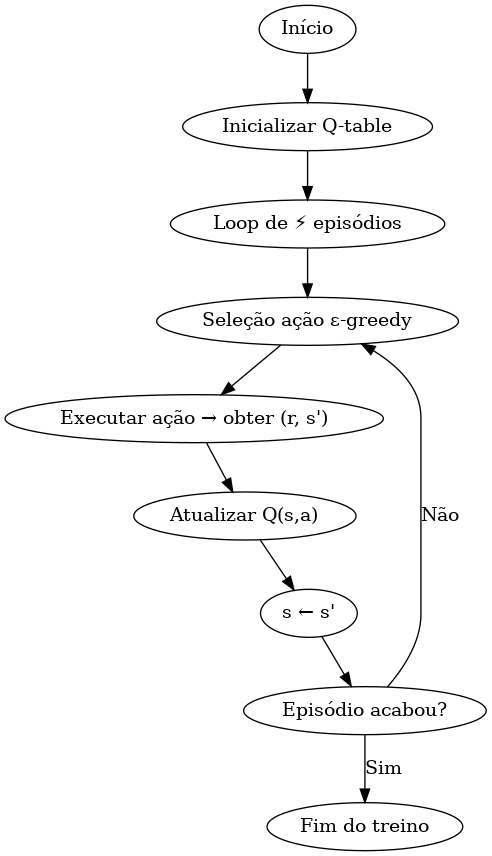

# Import & Config

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from sklearn.preprocessing import StandardScaler

# Aquisição e pré-processameno de dados

Vamos em busca dos preços históricos ajustados de VALE3, PETR4 e BRFS3, utilizando o pacote yfinance.
As datas podem ser alteradas pelos campos 'start' e 'end'.
Um tratamento simples de dropar os nulos é feito.

In [ ]:
# Coletando dados históricos dos ativos
tickers = ['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']
data = yf.download(tickers, start='2020-01-01', end='2025-05-31')['Close']
data = data.dropna()
data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,BRFS3.SA,PETR4.SA,VALE3.SA
Date,,,
2020-01-02,34.006203,9.304729,33.844028
2020-01-03,34.063068,9.228959,33.594852
2020-01-06,33.712391,9.338069,33.395515
2020-01-07,33.323803,9.301700,33.638458
2020-01-08,34.603302,9.244113,33.644691


# Definição do ambiente de negociação (custom gym)

Criamos um ambiente de simulação com a biblioteca gymnasium, onde o nosso agente de RL pode treinar e aprender.
Parâmetros iniciais:
* O agente começa com R$10.000.

A cada step (dia), ele decide:
* Manter a posição = 0
* Comprar = 1
* Vender = 2

Para cada um dos 3 ativos.

O ambiente calcula o valor da carteira (soma do saldo + valor dos ativos em carteira).

A recompensa (reward) em cada passo é a variação do valor da carteira.



In [ ]:
class TradingEnv(gym.Env):
    def __init__(self, data):
        super(TradingEnv, self).__init__()
        self.data = data
        self.n_assets = data.shape[1]
        self.n_steps = len(data)
        self.initial_balance = 10000

        # Definindo o espaço de ações: 0 = manter, 1 = comprar, 2 = vender (por ativo)
        self.action_space = spaces.Discrete(3 ** self.n_assets)

        # Estado: saldo em conta + preços atuais
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.n_assets * 3 + 1,), dtype=np.float32)

        self.reset()

    def get_total_asset(self):
        if self.current_step >= len(self.data):
            last_step = len(self.data) - 1
        else:
            last_step = self.current_step

        prices = self.data.iloc[last_step].values
        return self.balance + np.dot(self.asset_holdings, prices)

    # Reseta o ambiente
    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.asset_holdings = np.zeros(self.n_assets)
        self.total_asset_history = []
        self.total_value = self.get_total_asset()
        return self._get_observation()

    # Retorna o estado atual
    def _get_observation(self):
        prices = self.data.iloc[self.current_step].values
        return np.concatenate(([self.balance], prices))

    # Executa a ação e avança um dia
    def step(self, action):
        prices = self.data.iloc[self.current_step].values
        prev_value = self._get_portfolio_value(prices)

        # Decodificar ação
        actions = self._decode_action(action)
        for i, act in enumerate(actions):
            if act == 1:  # comprar
                qty = self.balance // prices[i]
                self.asset_holdings[i] += qty
                self.balance -= qty * prices[i]
            elif act == 2:  # vender
                self.balance += self.asset_holdings[i] * prices[i]
                self.asset_holdings[i] = 0

        # Avançar um dia
        self.current_step += 1
        done = self.current_step >= self.n_steps - 1

        # Recompensa
        next_prices = self.data.iloc[self.current_step].values
        next_value = self._get_portfolio_value(next_prices)
        # reward = (self.total_value - prev_value) / prev_value
        reward = (next_value - prev_value) / (prev_value + 1e-8 )

        return self._get_observation(), reward, done, {}

    def _decode_action(self, action):
        base = 3
        return [(action // base ** i) % base for i in range(self.n_assets)]

    def _get_portfolio_value(self, prices):
        return self.balance + np.sum(self.asset_holdings * prices)


# Agente Q-Learning

Aqui o agente cria uma Q-Table (tabela de valor-ação).

Para cada estado observado (saldo + preços atuais):
* Ele aprende qual ação (comprar, vender, manter) maximiza a recompensa esperada no futuro.

Ele age de forma ε-greedy, ou seja:
* Em 90% dos casos, ele escolhe a melhor ação conhecida (exploit).
* Em 10%, ele tenta uma aleatória (explore).

In [ ]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = n_actions

    def get_state_key(self, state):
        return tuple(np.round(state, 2))

    def act(self, state):
        key = self.get_state_key(state)
        if key not in self.q_table:
            self.q_table[key] = np.zeros(self.n_actions)

        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.q_table[key])

    def learn(self, state, action, reward, next_state):
        key = self.get_state_key(state)
        next_key = self.get_state_key(next_state)

        if next_key not in self.q_table:
            self.q_table[next_key] = np.zeros(self.n_actions)

        predict = self.q_table[key][action]
        target = reward + self.gamma * np.max(self.q_table[next_key])
        self.q_table[key][action] += self.alpha * (target - predict)


# Treinamento de Agente

Após o treinamento por 100 episódios, observamos que as recompensas totais variaram
bastante, com episódios lucrativos e outros com prejuízo. No entanto, a média nal foi 0.0, o
que indica que, em termos gerais, o agente não apresentou um desempenho consistente ao
longo do tempo.

Isso pode ser consequência de:

*   Uma política de ações ainda instável;
*   Parâmetros que não favorecem aprendizado (ex: epsilon constante, alpha baixo);
*   Simplesmente da complexidade do ambiente de trading, onde é difícil obter retorno positivo sem estratégias mais avançadas.





In [ ]:
# Cria o ambiente de simulação (ex: ambiente de ações ou frozen lake)
env = TradingEnv(data)

# Inicializa o agente com número de estados e ações possíveis
agent = QLearningAgent(
    n_states=env.observation_space.shape[0],
    n_actions=env.action_space.n
)

episodes = 100
rewards = []

# Loop de episódios de treino
for ep in range(episodes):

    total_reward = 0
    state = env.reset()  # começa um novo episódio
    done = False

    while not done:
        # O agente escolhe uma ação com base no estado atual
        action = agent.act(state)
        # Executa a ação no ambiente e observa o resultado
        next_state, reward, done, _ = env.step(action)
        # O agente atualiza sua Q-table com base no que aprendeu
        agent.learn(state, action, reward, next_state)
        # Avança para o próximo estado
        state = next_state
        # Soma a recompensa total do episódio
        total_reward += reward
    # Guarda recompensa final do episódio
    rewards.append(total_reward)

    if ep % 10 == 0:
        print(f"Episode {ep} | Total Reward: {total_reward:.2f}")

# Exibe a recompensa média obtida nos episódios
print(f"Recompensa média após {episodes} episódios: {np.mean(rewards)}")

Episode 0 | Total Reward: 0.36
Episode 10 | Total Reward: 0.61
Episode 20 | Total Reward: 1.83
Episode 30 | Total Reward: 0.45
Episode 40 | Total Reward: 0.44
Episode 50 | Total Reward: 0.96
Episode 60 | Total Reward: -0.90
Episode 70 | Total Reward: 1.16
Episode 80 | Total Reward: 0.99
Episode 90 | Total Reward: 0.23
Recompensa média após 100 episódios: 0.685094872471382


# Avaliação de Performance (Lucro final, Sharpe Ratio)

O gráfico demonstra que o agente aprendeu a variar suas decisões ao longo do tempo, mas não necessariamente a gerar lucro consistente. Apesar de oscilações no valor da carteira, o índice Sharpe Ratio próximo de zero indica baixa efetividade da estratégia aprendida. O comportamento ainda parece ser próximo do aleatório, o que sugere necessidade de mais treinamento ou ajustes no ambiente e nas recompensas.

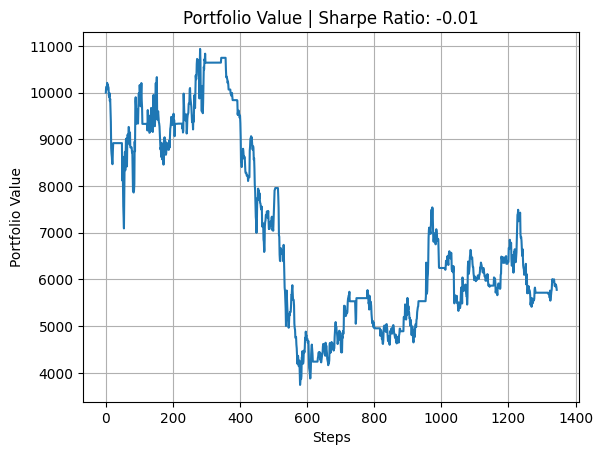

In [ ]:
def evaluate_agent(env, agent):
    state = env.reset()
    done = False
    portfolio_values = []
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        prices = env.data.iloc[env.current_step].values
        value = env._get_portfolio_value(prices)
        portfolio_values.append(value)
    return portfolio_values

values = evaluate_agent(env, agent)
returns = np.diff(values) / values[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns)

plt.plot(values)
plt.title(f'Portfolio Value | Sharpe Ratio: {sharpe_ratio:.2f}')
plt.xlabel('Steps')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


* Sharpe Ratio = (retorno médio - livre de risco) / volatilidade
Aqui, usamos retorno médio / desvio padrão (simplificado).

* Um valor baixo (<1) significa que os ganhos são baixos comparados ao risco — o agente ainda está aprendendo, ou as ações são voláteis demais para esse setup simples.


# Evolução do agente

Podemos tentar evoluir o agente aumentando a granularidade e complexidade.

Ao invés de só usar o preço atual, vamos usar indicadores técnicos: média móvel curta e longa, e retorno percentual diário.

*Também vamos normalizar os dados, usando StandardScaler para transformar os valores para média 0 e desvio padrão 1.*
Após testes notou-se que normalizar os dados estava atrapalhando o agente, então foi decidido seguir sem a normalização.

É preciso reconfigurar o ambiente para usar as novas informações como estado.

Precisamos chamar novamente a classe tradingEnv, ajustada para as novas features

In [ ]:
# 1. Adiciona indicadores técnicos + normaliza os dados
def preprocess_data(data):
    df = data.copy()

    # Indicadores técnicos para cada ativo
    for ticker in df.columns:
        df[f'MA5_{ticker}'] = df[ticker].rolling(window=5).mean()
        df[f'MA20_{ticker}'] = df[ticker].rolling(window=20).mean()
        df[f'MOM_{ticker}'] = df[ticker].pct_change()

    df = df.dropna()
    return df

# 2. Carrega os dados e aplica preprocessamento
tickers = ['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']
raw_data = yf.download(tickers, start='2020-01-01', end='2025-05-31')['Close']
data = preprocess_data(raw_data)

data.head(5)

[*********************100%***********************]  3 of 3 completed


Ticker,BRFS3.SA,PETR4.SA,VALE3.SA,MA5_BRFS3.SA,MA20_BRFS3.SA,MOM_BRFS3.SA,MA5_PETR4.SA,MA20_PETR4.SA,MOM_PETR4.SA,MA5_VALE3.SA,MA20_VALE3.SA,MOM_VALE3.SA
Date,,,,,,,,,,,,
2020-01-29,29.475832,8.744020,31.613920,30.880437,33.341338,-0.008291,8.767055,9.041196,0.001736,32.611862,33.842782,-0.008789
2020-01-30,29.001945,8.771297,32.081123,30.076723,33.091125,-0.016077,8.724017,9.014525,0.003120,32.113514,33.754637,0.014778
2020-01-31,28.954556,8.622787,31.314909,29.454981,32.835699,-0.001634,8.672492,8.984216,-0.016931,31.673721,33.640639,-0.023884
2020-02-03,29.921288,8.540954,31.713591,29.415175,32.646144,0.033388,8.681585,8.944360,-0.009490,31.723557,33.556543,0.012731
2020-02-04,30.499430,8.677342,32.560780,29.570610,32.504926,0.019322,8.671280,8.913143,0.015969,31.856865,33.502659,0.026714


In [ ]:
# 3. Ambiente com indicadores
class TradingEnvIndicators(gym.Env):
    def __init__(self, data):
        super(TradingEnvIndicators, self).__init__()
        self.data = data
        self.n_assets = 3  # VALE3, PETR4, BRFS3
        self.n_steps = len(data)
        self.initial_balance = 10000

        # Espaço de ação: 3 possibilidades (manter, comprar, vender) por ativo
        self.action_space = spaces.Discrete(3 ** self.n_assets)

        # Espaço de observação: saldo + todas features numéricas
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(1 + data.shape[1],),
            dtype=np.float32
        )

        self.reset()

    # Reseta o ambiente
    def reset(self):
        self.current_step = np.random.randint(0, self.n_steps - 50)  # evita final dos dados
        self.balance = self.initial_balance
        self.asset_holdings = np.zeros(self.n_assets)
        return self._get_observation()

    # Retorna o estado atual
    def _get_observation(self):
        obs = np.concatenate(([self.balance], self.data.iloc[self.current_step].values))
        return obs

    # Executa a ação e avança um dia
    def step(self, action):
        prices = self.data.iloc[self.current_step][['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']].values
        prev_value = self._get_portfolio_value(prices)

        actions = self._decode_action(action)
        for i, act in enumerate(actions):
            if act == 1:  # comprar
                qty = self.balance // prices[i]
                self.asset_holdings[i] += qty
                self.balance -= qty * prices[i]
            elif act == 2:  # vender
                self.balance += self.asset_holdings[i] * prices[i]
                self.asset_holdings[i] = 0

        self.current_step += 1
        done = self.current_step >= self.n_steps - 1

        next_prices = self.data.iloc[self.current_step][['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']].values
        next_value = self._get_portfolio_value(next_prices)

# Reward engineering -> a depender da recompensa escolhida podemos ter um resultado melhor ou pior
        #reward = next_value - prev_value # (lucro bruto)
        #reward = np.log(next_value / prev_value) # (log-return)
        reward = (next_value - prev_value) / (prev_value + 1e-8 ) # (Lucro por acao) 0.07

        return self._get_observation(), reward, done, {}

    def _decode_action(self, action):
        base = 3
        return [(action // base ** i) % base for i in range(self.n_assets)]

    def _get_portfolio_value(self, prices):
        return self.balance + np.sum(self.asset_holdings * prices)

O mesmo para chamar o QLearningAgent

In [ ]:
# 4. Chama o Agente

class QLearningAgentIndicators:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_actions = n_actions

    def get_state_key(self, state):
        return tuple(np.round(state, 2))

    def act(self, state):
        key = self.get_state_key(state)
        if key not in self.q_table:
            self.q_table[key] = np.zeros(self.n_actions)

        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.q_table[key])

    def learn(self, state, action, reward, next_state):
        key = self.get_state_key(state)
        next_key = self.get_state_key(next_state)

        if next_key not in self.q_table:
            self.q_table[next_key] = np.zeros(self.n_actions)

        predict = self.q_table[key][action]
        target = reward + self.gamma * np.max(self.q_table[next_key])
        self.q_table[key][action] += self.alpha * (target - predict)

E agora o bloco principal com: dados, indicadores, treinamento e avaliação, com as novas features e normalização dos dados.

In [ ]:
# 5. Treinamento
env = TradingEnvIndicators(data)
agent = QLearningAgentIndicators(n_states=env.observation_space.shape[0], n_actions=env.action_space.n)

episodes = 100

for ep in range(episodes):

    total_reward = 0
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if ep % 10 == 0:
        print(f"Episode {ep} | Total Reward: {total_reward:.2f}")

Episode 0 | Total Reward: 0.27
Episode 10 | Total Reward: 0.28
Episode 20 | Total Reward: 0.34
Episode 30 | Total Reward: -0.25
Episode 40 | Total Reward: 0.44
Episode 50 | Total Reward: -0.27
Episode 60 | Total Reward: -0.15
Episode 70 | Total Reward: 0.77
Episode 80 | Total Reward: 0.83
Episode 90 | Total Reward: -0.44


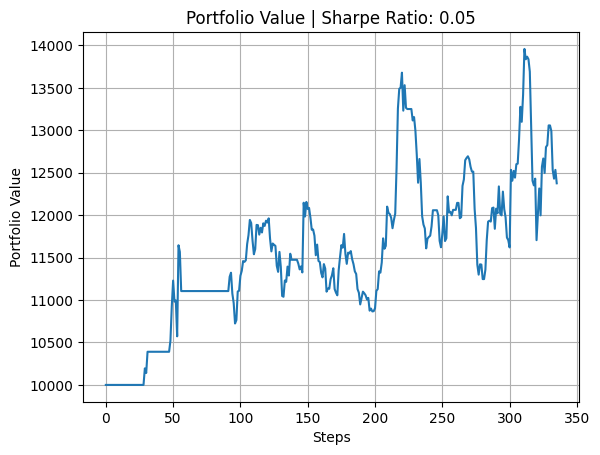

In [ ]:
# 6. Avaliação
def evaluate_agent(env, agent):
    state = env.reset()
    done = False
    portfolio_values = []
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        prices = env.data.iloc[env.current_step][['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']].values
        value = env._get_portfolio_value(prices)
        portfolio_values.append(value)
    return portfolio_values

values = evaluate_agent(env, agent)
returns = np.diff(values) / values[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns)

plt.plot(values)
plt.title(f'Portfolio Value | Sharpe Ratio: {sharpe_ratio:.2f}')
plt.xlabel('Steps')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

O Sharpe ratio continua muito próximo de zero, mas melhorou, mesmo ainda não justificando o uso do modelo devido ao baixo retorno e alto risco.

# Validação cruzada

Vamos dividir os dados em dois blocos para fazer o treinamento e o teste.
* Treinamento: 2020-2024
* Teste: 2025

In [ ]:
# ---------------------------
# 1. Pré-processamento de dados
# ---------------------------

def preprocess_data(data):
    df = data.copy()

    # Adiciona indicadores técnicos (Rolling médios e momentum)
    df['MA5_VALE3'] = df['VALE3.SA'].rolling(window=5).mean()
    df['MA20_VALE3'] = df['VALE3.SA'].rolling(window=20).mean()
    df['MOM_VALE3'] = df['VALE3.SA'].pct_change()

    df['MA5_PETR4'] = df['PETR4.SA'].rolling(window=5).mean()
    df['MA20_PETR4'] = df['PETR4.SA'].rolling(window=20).mean()
    df['MOM_PETR4'] = df['PETR4.SA'].pct_change()

    df['MA5_BRFS3'] = df['BRFS3.SA'].rolling(window=5).mean()
    df['MA20_BRFS3'] = df['BRFS3.SA'].rolling(window=20).mean()
    df['MOM_BRFS3'] = df['BRFS3.SA'].pct_change()

    df = df.dropna()

    # Normalização
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df_scaled

# ---------------------------
# 2. Ambiente de Treinamento
# ---------------------------

class TradingEnvCruzada:
    def __init__(self, data, initial_balance=10000):
        self.data = data
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = 20  # Para garantir cálculo das médias móveis
        self.balance = self.initial_balance
        self.asset_holdings = np.zeros(self.data.shape[1])
        self.total_asset_history = []
        return self._next_observation()

    def _next_observation(self):
        prices = self.data.iloc[self.current_step].values
        moving_avg_short = self.data.rolling(window=5).mean().iloc[self.current_step].values
        moving_avg_long = self.data.rolling(window=20).mean().iloc[self.current_step].values
        momentum = self.data.pct_change().iloc[self.current_step].values

        moving_avg_short = np.nan_to_num(moving_avg_short, nan=prices)
        moving_avg_long = np.nan_to_num(moving_avg_long, nan=prices)
        momentum = np.nan_to_num(momentum, nan=0)

        portfolio_info = np.append(self.asset_holdings, self.balance)
        state = np.concatenate((prices, moving_avg_short, moving_avg_long, momentum, portfolio_info))
        return state

    def step(self, actions):
        prices = self.data.iloc[self.current_step].values

        for i, action in enumerate(actions):
            if action == 1:  # Comprar
                if self.balance >= prices[i]:
                    self.asset_holdings[i] += 1
                    self.balance -= prices[i]
            elif action == -1:  # Vender
                if self.asset_holdings[i] > 0:
                    self.asset_holdings[i] -= 1
                    self.balance += prices[i]
            # 0 = manter

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        new_prices = self.data.iloc[self.current_step].values
        total_asset = self.balance + np.dot(self.asset_holdings, new_prices)
        self.total_asset_history.append(total_asset)

        reward = total_asset - (self.balance + np.dot(self.asset_holdings, prices))
        return self._next_observation(), reward, done, {}

    def get_total_asset(self):
        prices = self.data.iloc[self.current_step].values
        return self.balance + np.dot(self.asset_holdings, prices)

# ---------------------------
# 3. Agente Q-Learning
# ---------------------------

class QLearningAgentCruzada:
    def __init__(self, state_size, action_size, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, alpha=0.1, gamma=0.95):
        self.q_table = {}
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma

    def get_state_key(self, state):
        return tuple(np.round(state, 4))  # discretiza para usar como chave

    def act(self, state):
        state_key = self.get_state_key(state)
        if np.random.rand() <= self.epsilon:
            return np.random.choice([-1, 0, 1], size=int(self.action_size))
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros((self.action_size, 3))  # 3 ações: -1, 0, 1
        return np.argmax(self.q_table[state_key] - 1, axis=1) - 1  # transforma índice em ação

    def learn(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros((self.action_size, 3))
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros((self.action_size, 3))

        for i in range(self.action_size):
            a_idx = action[i] + 1  # mapeia -1,0,1 → 0,1,2
            future_q = np.max(self.q_table[next_state_key][i])
            self.q_table[state_key][i][a_idx] += self.alpha * (reward + self.gamma * future_q - self.q_table[state_key][i][a_idx])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ---------------------------
# 4. Validação temporal (Walk-forward)
# ---------------------------

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    returns = np.array(returns)
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns) if np.std(returns) != 0 else 0

def compare_with_market(test_data, asset_history):
    market_returns = test_data.mean(axis=1).pct_change().dropna()
    agent_returns = np.diff(asset_history) / asset_history[:-1]

    sharpe_agent = calculate_sharpe_ratio(agent_returns)
    sharpe_market = calculate_sharpe_ratio(market_returns.values)

    print(f"\n📈 Sharpe do Agente: {sharpe_agent:.4f}")
    print(f"📉 Sharpe do Mercado: {sharpe_market:.4f}")
    return sharpe_agent, sharpe_market

def temporal_cross_validation(data, n_splits=3, start_year=2020, end_year=2025):
    date_range = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31")
    available_dates = data.index.intersection(date_range)

    if len(available_dates) < 300:
        print("Poucos dados disponíveis nesse intervalo. Verifique o download.")
        return []

    data = data.loc[available_dates]
    split_size = len(data) // (n_splits + 1)
    sharpe_ratios = []

    for i in range(n_splits):
        train_data = data.iloc[i*split_size:(i+1)*split_size]
        test_data = data.iloc[(i+1)*split_size:(i+2)*split_size]

        print(f"\n🔍 Split {i+1}/{n_splits}:")
        print(f"Treinando de {train_data.index[0].date()} até {train_data.index[-1].date()}")
        print(f"Testando  de {test_data.index[0].date()} até {test_data.index[-1].date()}")

        env = TradingEnvCruzada(train_data)
        state = env.reset()
        agent = QLearningAgentCruzada(state_size=len(state), action_size=3)  # 3 ativos

        for _ in range(100):  # Episódios de treino
            state = env.reset()
            done = False
            while not done:
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.learn(state, action, reward, next_state)
                state = next_state

        test_env = TradingEnvCruzada(test_data)
        state = test_env.reset()
        done = False
        asset_history = [test_env.get_total_asset()]

        while not done:
            action = agent.act(state)
            state, _, done, _ = test_env.step(action)
            asset_history.append(test_env.get_total_asset())

        # returns = np.diff(asset_history) / asset_history[:-1]
        # sharpe = calculate_sharpe_ratio(returns)
        # sharpe_ratios.append(sharpe)

        sharpe_agent, sharpe_market = compare_with_market(test_data, asset_history)
        sharpe_ratios.append(sharpe_agent)

        # print(f"✅ Sharpe Ratio: {sharpe:.4f}")

    print(f"\n📊 Média Sharpe Ratio: {np.mean(sharpe_ratios):.4f}")
    return sharpe_ratios

tickers = ['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']
raw_data = yf.download(tickers, start='2020-01-01', end='2025-12-31')['Close']
data = preprocess_data(raw_data)

sharpes = temporal_cross_validation(data, n_splits=3, start_year=2020, end_year=2025)

[*********************100%***********************]  3 of 3 completed



🔍 Split 1/3:
Treinando de 2020-01-29 até 2021-06-04
Testando  de 2021-06-07 até 2022-10-03

📈 Sharpe do Agente: 0.0567
📉 Sharpe do Mercado: -0.0962

🔍 Split 2/3:
Treinando de 2021-06-07 até 2022-10-03
Testando  de 2022-10-04 até 2024-02-05

📈 Sharpe do Agente: 0.0550
📉 Sharpe do Mercado: 0.0518

🔍 Split 3/3:
Treinando de 2022-10-04 até 2024-02-05
Testando  de 2024-02-06 até 2025-06-06

📈 Sharpe do Agente: -0.0557
📉 Sharpe do Mercado: 0.0521

📊 Média Sharpe Ratio: 0.0187


###Interpretação

Apesar do uso de técnicas como enriquecimento de estado, tuning de hiperparâmetros e decaimento de epsilon, o agente **apresentou dificuldade em manter desempenho consistente** ao longo do tempo. O único split com performance claramente superior ao mercado foi o primeiro — o que pode refletir um caso de overfitting ou um ambiente de mercado mais previsível naquele intervalo.

A validação cruzada temporal mostrou ser crucial para evitar falsas impressões de aprendizado. Se tivéssemos avaliado apenas um intervalo, os resultados poderiam indicar sucesso, quando na verdade a estratégia **falha ao se adaptar a novos contextos de mercado**.


###Conclusão prática:

A validação temporal revelou que:
- O agente é capaz de aprender em alguns contextos, mas não generaliza bem.
- O uso de Q-Learning tabular enfrenta limitações frente à complexidade e variabilidade do mercado real.

tuning de hiperparâmetros com validacao temporal e grid search

In [ ]:
# ---------------------------
# 1. Pré-processamento de dados
# ---------------------------

def preprocess_data(data):
    df = data.copy()
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df_scaled

# ---------------------------
# 2. Ambiente de Treinamento
# ---------------------------

class TradingEnvTuning:
    def __init__(self, data, initial_balance=10000):
        self.data = data
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = 20  # Para garantir cálculo das médias móveis
        self.balance = self.initial_balance
        self.asset_holdings = np.zeros(self.data.shape[1])
        self.total_asset_history = []
        return self._next_observation()

    def _next_observation(self):
        prices = self.data.iloc[self.current_step].values
        moving_avg_short = self.data.rolling(window=5).mean().iloc[self.current_step].values
        moving_avg_long = self.data.rolling(window=20).mean().iloc[self.current_step].values
        momentum = self.data.pct_change().iloc[self.current_step].values

        moving_avg_short = np.nan_to_num(moving_avg_short, nan=prices)
        moving_avg_long = np.nan_to_num(moving_avg_long, nan=prices)
        momentum = np.nan_to_num(momentum, nan=0)

        portfolio_info = np.append(self.asset_holdings, self.balance)
        state = np.concatenate((prices, moving_avg_short, moving_avg_long, momentum, portfolio_info))
        return state

    def step(self, actions):
        prices = self.data.iloc[self.current_step].values

        for i, action in enumerate(actions):
            if action == 1:  # Comprar
                if self.balance >= prices[i]:
                    self.asset_holdings[i] += 1
                    self.balance -= prices[i]
            elif action == -1:  # Vender
                if self.asset_holdings[i] > 0:
                    self.asset_holdings[i] -= 1
                    self.balance += prices[i]
            # 0 = manter

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        new_prices = self.data.iloc[self.current_step].values
        total_asset = self.balance + np.dot(self.asset_holdings, new_prices)
        self.total_asset_history.append(total_asset)

        reward = total_asset - (self.balance + np.dot(self.asset_holdings, prices))
        return self._next_observation(), reward, done, {}

    def get_total_asset(self):
        prices = self.data.iloc[self.current_step].values
        return self.balance + np.dot(self.asset_holdings, prices)

# ---------------------------
# 3. Agente Q-Learning
# ---------------------------

class QLearningAgentTuning:
    def __init__(self, state_size, action_size, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, alpha=0.1, gamma=0.95):
        self.q_table = {}
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma

    def get_state_key(self, state):
        return tuple(np.round(state, 4))  # discretiza para usar como chave

    def act(self, state):
        state_key = self.get_state_key(state)
        if np.random.rand() <= self.epsilon:
            return np.random.choice([-1, 0, 1], size=int(self.action_size))
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros((self.action_size, 3))  # 3 ações: -1, 0, 1
        return np.argmax(self.q_table[state_key] - 1, axis=1) - 1  # transforma índice em ação

    def learn(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros((self.action_size, 3))
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros((self.action_size, 3))

        for i in range(self.action_size):
            a_idx = action[i] + 1  # mapeia -1,0,1 → 0,1,2
            future_q = np.max(self.q_table[next_state_key][i])
            self.q_table[state_key][i][a_idx] += self.alpha * (reward + self.gamma * future_q - self.q_table[state_key][i][a_idx])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ---------------------------
# 4. Validação temporal (Walk-forward)
# ---------------------------

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    returns = np.array(returns)
    excess_returns = returns - risk_free_rate
    if returns.std() == 0:
        return 0
    return np.mean(excess_returns) / np.std(excess_returns)

def temporal_cross_validation(data, n_splits=3, q_params=None):
    window_size = len(data) // (n_splits + 1)
    sharpe_ratios = []

    for i in range(n_splits):
        train_start = i * window_size
        train_end = (i + 1) * window_size
        test_end = (i + 2) * window_size

        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[train_end:test_end]

        env = TradingEnvTuning(train_data)
        state = env.reset()

        agent = QLearningAgentTuning(
            state_size=len(state),
            action_size=train_data.shape[1],
            alpha=q_params.get("alpha", 0.1),
            gamma=q_params.get("gamma", 0.95),
            epsilon=q_params.get("epsilon", 1.0),
            epsilon_decay=q_params.get("epsilon_decay", 0.995),
            epsilon_min=q_params.get("epsilon_min", 0.01)
        )

        for _ in range(100):  # Episódios de treino
            state = env.reset()
            done = False
            while not done:
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.learn(state, action, reward, next_state)
                state = next_state

        test_env = TradingEnvTuning(test_data)
        state = test_env.reset()
        done = False
        asset_history = []

        while not done:
            action = agent.act(state)
            state, _, done, _ = test_env.step(action)
            asset_history.append(test_env.get_total_asset())

        returns = np.diff(asset_history) / asset_history[:-1]
        sharpe = calculate_sharpe_ratio(returns)
        sharpe_ratios.append(sharpe)

        print(f"Split {i+1}/{n_splits} | Sharpe: {sharpe:.4f} | Params: {q_params}")

    return sharpe_ratios


In [ ]:
def grid_search(data, param_grid, n_splits=3):
    import itertools

    keys = list(param_grid.keys())
    combinations = list(itertools.product(*param_grid.values()))

    best_score = -np.inf
    best_params = None
    all_results = []

    for values in combinations:
        q_params = dict(zip(keys, values))
        sharpe_scores = temporal_cross_validation(data, n_splits=n_splits, q_params=q_params)
        mean_score = np.mean(sharpe_scores)
        all_results.append((q_params, mean_score))

        if mean_score > best_score:
            best_score = mean_score
            best_params = q_params

    print("\n🏆 Melhor combinação:")
    print(f"Params: {best_params}")
    print(f"Sharpe Médio: {best_score:.4f}")

    return best_params, all_results

In [ ]:
param_grid = {
    'epsilon': [1.0, 0.5],
    'epsilon_min': [0.05],
    'epsilon_decay': [0.99, 0.995],
    'alpha': [0.1, 0.01],
    'gamma': [0.9, 0.95]
}

# Execute
best_params, best_score = grid_search(data, param_grid, n_splits=2)


Split 1/2 | Sharpe: -0.0004 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha': 0.1, 'gamma': 0.9}
Split 2/2 | Sharpe: -0.1129 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha': 0.1, 'gamma': 0.9}
Split 1/2 | Sharpe: 0.0301 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha': 0.1, 'gamma': 0.95}
Split 2/2 | Sharpe: -0.0737 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha': 0.1, 'gamma': 0.95}
Split 1/2 | Sharpe: -0.0045 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha': 0.01, 'gamma': 0.9}
Split 2/2 | Sharpe: -0.0014 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha': 0.01, 'gamma': 0.9}
Split 1/2 | Sharpe: 0.0173 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha': 0.01, 'gamma': 0.95}
Split 2/2 | Sharpe: -0.0426 | Params: {'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'alpha':

# Conclusão
Neste trabalho, desenvolvemos e avaliamos um agente de Aprendizagem por Reforço (RL) baseado no algoritmo Q-Learning, capaz de operar um portfólio composto pelos ativos VALE3, PETR4 e BRFS3. O ambiente de simulação foi construído de forma customizada utilizando a biblioteca Gym, incorporando decisões de compra, venda ou manutenção para cada ativo a partir de dados históricos coletados pelo Yahoo Finance.

Com base nas descobertas feitas durante a validação cruzada temporal, o modelo atual foi ajustado para incorporar uma estrutura de treinamento segmentada por períodos de tempo. Essa abordagem permite avaliar o desempenho do agente em cenários mais realistas e dinâmicos, alinhados com a natureza evolutiva do mercado financeiro. O uso dessa estratégia se mostrou essencial para revelar limitações de generalização do agente, que não seriam detectadas com uma validação tradicional.

Apesar de termos enriquecido o estado do agente com indicadores técnicos como médias móveis e momentum, e de testarmos diferentes combinações de hiperparâmetros por meio de grid search, os resultados apontaram que o agente apresentou desempenho ainda próximo do aleatório, sem superar consistentemente estratégias simples como Buy & Hold. O Sharpe Ratio médio permaneceu próximo de zero, indicando baixo retorno ajustado ao risco.

Essa dificuldade era esperada, dado que o ambiente financeiro é altamente complexo e apresenta espaço de estados muito amplo para ser eficientemente explorado por uma abordagem tabular como o Q-Learning. Além disso, a ausência de custos de transação e o horizonte de tempo relativamente curto podem ter limitado o realismo da simulação. Ainda assim, a implementação demonstrou a viabilidade da aplicação de RL para simulações financeiras e possibilitou o aprendizado sobre os principais desafios desse tipo de abordagem.

# Insights Extraídos da Validação Temporal
- ❎ **Falta de generalização**: O modelo aprendeu padrões do período de treino, mas não conseguiu transferir isso para o período de teste.
- ❎ **Possível overfitting**: O bom desempenho no treino versus o fraco desempenho no teste indica que o agente está aprendendo padrões específicos demais.
- ❎ **Validação temporal foi essencial**: Revelou a fragilidade da estratégia, algo que não apareceria com validação comum.
- ❎ **Uso ineficiente de indicadores**: Apesar de incluir médias móveis e momentum, o agente não demonstrou uso efetivo desses sinais.
- ❎ **Limitação do Q-Learning tabular**: Em ambientes com muitos ativos e estados contínuos, pode ser necessário testar DQN ou abordagens híbridas.

# Ações Adotadas
- Implementamos um processo de **validação temporal com ajuste de hiperparâmetros via grid search**.
- Testamos combinações de `epsilon`, `alpha`, `gamma` e `epsilon_decay`, visando maximizar o Sharpe Ratio em diferentes cenários de mercado.
- O ambiente foi mantido com features técnicos e um controle preciso de portfólio com recompensas baseadas em valor total.


# Próximo Passos

Para avançar, recomendamos implementar métodos mais sofisticados de RL, como Deep Q-Networks (DQN), que utilizam redes neurais para lidar com ambientes de alta dimensionalidade, além de aprimorar a função de recompensa incluindo custos de transação e penalidades por excesso de operações. A introdução de validação temporal mais rigorosa, simulação de restrições reais do mercado e comparação direta com estratégias clássicas também são essenciais para obter uma avaliação mais realista do desempenho do agente.

Além disso, sugerimos ampliar a base de dados, testando diferentes ativos e períodos de mercado, e enriquecer o estado do agente com variáveis econômicas adicionais. Esses avanços devem tornar a simulação mais robusta e aproximar o modelo das condições enfrentadas em aplicações práticas de fundos quantitativos automatizados.